In [2]:
import numpy as np
import nibabel as nib

from utils import calculate_dice_score
from em_algo import ExpectationMaximization

## Load Data

In [71]:
patient = 3

In [72]:
# Load the two NIfTI images
T1_path = f'data/{patient}/T1.nii'
T2_path = f'data/{patient}/T2_FLAIR.nii'
label_path = f'data/{patient}/LabelsForTesting.nii'

### Load the images from the path
T1 = nib.load(T1_path)
T1_np_img = T1.get_fdata()
T2 = nib.load(T2_path)
T2_np_img = T2.get_fdata()
labels = nib.load(label_path)
labels_np_img = labels.get_fdata()

In [73]:
# Perform Skull Stripping to get the brain mask for WM, GM, and CSF
## Isolate the brain voxels using the label
#### Get the indices of the brain voxels
brain_voxels_indices = np.where(labels_np_img > 0)
#### Get the brain voxels from the T1 image using the indices get from the label
T1_skull_stripped = T1_np_img[brain_voxels_indices]
T2_skull_stripped = T2_np_img[brain_voxels_indices]

### Stack the T1 and T2 images to get the multi-modal image
X = np.vstack((T1_skull_stripped, T2_skull_stripped)).T

## EM Algorithm

Iteration:  0  --- Log Likelihood:  2.737341214244705  --- Time (s):  0.09628701210021973


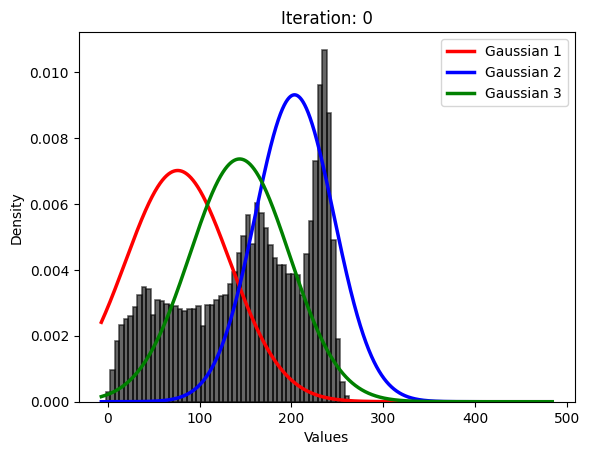

Iteration:  1  --- Log Likelihood:  2.947176235883974  --- Time (s):  0.1201620101928711
Iteration:  2  --- Log Likelihood:  3.0441685414463713  --- Time (s):  0.09139490127563477
Iteration:  3  --- Log Likelihood:  3.0770604676133653  --- Time (s):  0.08187079429626465
Iteration:  4  --- Log Likelihood:  3.0876641069608115  --- Time (s):  0.08039689064025879
Iteration:  5  --- Log Likelihood:  3.0918002828347904  --- Time (s):  0.08347606658935547
Iteration:  6  --- Log Likelihood:  3.0936069776418025  --- Time (s):  0.08281993865966797
Iteration:  7  --- Log Likelihood:  3.0945603461009545  --- Time (s):  0.0808858871459961
Iteration:  8  --- Log Likelihood:  3.095203274816747  --- Time (s):  0.08202600479125977
Iteration:  9  --- Log Likelihood:  3.0957274435728452  --- Time (s):  0.09051299095153809
Iteration:  10  --- Log Likelihood:  3.0961930381016023  --- Time (s):  0.08424806594848633
Iteration:  11  --- Log Likelihood:  3.0966121476806414  --- Time (s):  0.0827939510345459
It

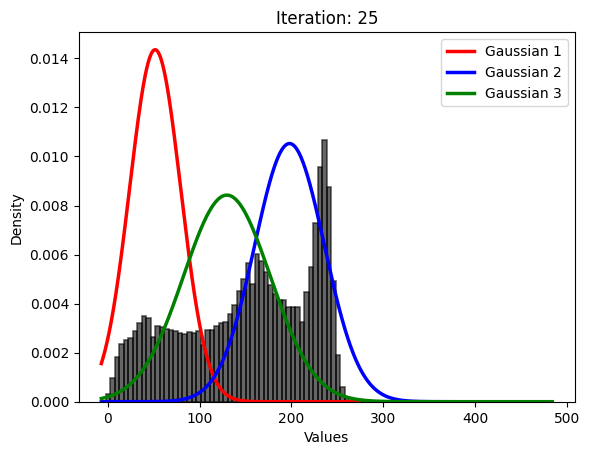

Iteration:  26  --- Log Likelihood:  3.097157117364831  --- Time (s):  0.1264667510986328
Iteration:  27  --- Log Likelihood:  3.0970265590239983  --- Time (s):  0.08345699310302734
Iteration:  28  --- Log Likelihood:  3.09690166672367  --- Time (s):  0.0814061164855957
Iteration:  29  --- Log Likelihood:  3.096783918229235  --- Time (s):  0.08323979377746582
Iteration:  30  --- Log Likelihood:  3.0966742163150234  --- Time (s):  0.08440399169921875
Iteration:  31  --- Log Likelihood:  3.09657300780586  --- Time (s):  0.08292317390441895
Iteration:  32  --- Log Likelihood:  3.0964803903559965  --- Time (s):  0.09289097785949707
Iteration:  33  --- Log Likelihood:  3.0963962041328355  --- Time (s):  0.08685493469238281
Iteration:  34  --- Log Likelihood:  3.09632010781941  --- Time (s):  0.08133101463317871
Iteration:  35  --- Log Likelihood:  3.0962516397358217  --- Time (s):  0.0889432430267334
Iteration:  36  --- Log Likelihood:  3.096190265637126  --- Time (s):  0.09103631973266602


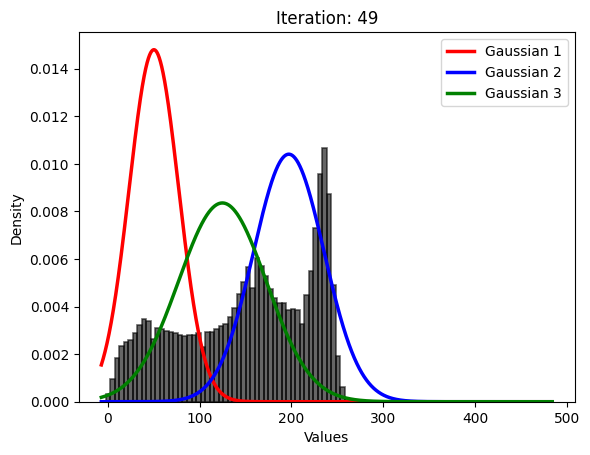

In [74]:
# Initialize the Expectation Maximization algorithm
em = ExpectationMaximization(X, k=3, max_iter=50, type='kmeans', plot_step=25, save_path='results/', show_plot=True, stop_criterion=1e-6)
alphas, mus, covars, W = em.fit()

## Postprocessing

Sort the means of the Gaussian components. This helps us map the classes to the intensity ranges.  
	•	The smallest mean will be assigned to CSF (1).  
	•	The middle mean will be assigned to GM (2).  
	•	The largest mean will be assigned to WM (3).  

In [75]:
# Assign each voxel to the cluster with the highest probability
voxel_assignments = np.argmax(W, axis=1)  # Get the index of the highest responsibility for each voxel
# Create a new 3D image with the same shape as the original brain image
segmented_image = np.zeros_like(T1_np_img)
# Map the voxel assignments back to the 3D segmented image using the brain_voxels_indices
segmented_image[brain_voxels_indices] = voxel_assignments + 1  # +1 to make the clusters 1, 2, 3

In [76]:
## 1 - CSF, 2 - GM, 3 - WM 
## Sort the clusters based on the mean intensity of the voxels in each cluster
sorted_mean_indices = np.argsort(np.mean(mus, axis=1)) + 1
## Assign the clusters to the correct class
class1_idx = np.where(segmented_image == sorted_mean_indices[0])
class2_idx = np.where(segmented_image == sorted_mean_indices[1])
class3_idx = np.where(segmented_image == sorted_mean_indices[2])
segmented_image[class1_idx] = 1
segmented_image[class2_idx] = 2
segmented_image[class3_idx] = 3

# Save the segmented image
segmented_img_nifti = nib.Nifti1Image(segmented_image, T1.affine)
nib.save(segmented_img_nifti, 'results/segmented_brain.nii')

print("Segmented brain image saved as 'results/segmented_brain.nii'")

Segmented brain image saved as 'results/segmented_brain.nii'


## Evaluation

In [77]:
# Calculate the Dice score between the predicted labels and the ground truth
dice_scores = calculate_dice_score(label_path, 'results/segmented_brain.nii')    
print(dice_scores)
print('Average Dice Score: ', np.mean(list(dice_scores.values())))

{1: 0.775460725562214, 2: 0.21763764943593197, 3: 0.6252673654462221}
Average Dice Score:  0.5394552468147894
